# Study of the results of the VAE for Multiple Circles

In this notebook we study the results of the VAE trained on the multiple circles dataset.
This are the things we do :
   1. We look at the output of the VAE given testing data,
   2. We try to predict one modality (PI or density) given only the other one,
   3. We study the latent distribution
   4. We draw a random $z_{joint}$ and passe it throw the decoder to see the output
   5. We try to go from one to two circles

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from time import time

import gudhi as gd
import gudhi.representations

from tqdm import tqdm

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from scipy.stats import multivariate_normal

from sklearn.neighbors import KernelDensity

### We strat by loading the VAE

In [3]:
vae = tf.keras.models.load_model('../Trained_VAE/VAE_full_multiple_circles/')
vae.summary()

2021-07-29 17:23:38.368803: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-29 17:23:38.615622: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-29 17:23:38.615878: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 960M computeCapability: 5.0
coreClock: 1.176GHz coreCount: 5 deviceMemorySize: 1.96GiB deviceMemoryBandwidth: 74.65GiB/s
2021-07-29 17:23:38.615916: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-29 17:23:38.616181: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No suc

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_PI (Encoder_PI)      multiple                  250706    
_________________________________________________________________
decoder_PI (Decoder_PI)      multiple                  252900    
_________________________________________________________________
encoder_PC (Encoder_PC)      multiple                  255456    
_________________________________________________________________
decoder_PC (Decoder_PC)      multiple                  528000    
_________________________________________________________________
sampling_5 (Sampling)        multiple                  0         
_________________________________________________________________
decoder_PC (Shared_Decoder)  multiple                  506       
_________________________________________________________________
cubical_layer_5 (CubicalLaye multiple                  

We then load the data and normalize the inputs

In [4]:
data = np.load('../data/PI_data_multiple_circle_density.npz')

PC_train = data["data_train"]
PI_train = data["PI_train"]
density_train = data["density_train"]
PC_test = data["data_test"]
PI_test = data["PI_test"]
density_test = data["density_test"]

N_sets_train = PC_train.shape[0]
N_sets_test = PC_test.shape[0]
N_points = PC_train.shape[1]
PI_size = int(np.sqrt(PI_train.shape[1]))
size = int(np.sqrt(density_test.shape[1]))
dim = 2
batch_size = 64

print("N_sets_train : ", N_sets_train)
print("N_sets_test : ", N_sets_test)
print("N_points : ", N_points)
print("PI_size : ", PI_size)
print("Size : ", size)

PI_train /= max(np.max(PI_train), np.max(PI_test))
PI_test /= max(np.max(PI_test), np.max(PI_test))

for i in range(N_sets_train):
    density_train[i] /= np.max(density_train[i])
for i in range(N_sets_test):
    density_test[i] /= np.max(density_test[i])

N_sets_train :  9999
N_sets_test :  999
N_points :  600
PI_size :  50
Size :  50


### Study of the output given a input the VAE hasn't seen

In [5]:
PI_pred, PC_pred = vae((PI_test, density_test))

2021-07-29 17:23:46.901931: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-29 17:23:46.950812: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2599990000 Hz


This are the output of the VAE

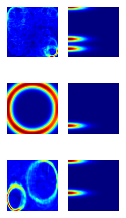

In [18]:
plt.figure(figsize=(2, 4))

for i in range(3):
    plt.subplot(3, 2, 2 * i + 2)
    plt.imshow(np.flip(np.reshape(PI_pred[i+j], [PI_size, PI_size]), 0),
               vmin=0,
               vmax=1,
               cmap='jet')
    #plt.colorbar()
    plt.axis('off')
    plt.subplot(3, 2, 2 * i + 1)
    plt.imshow(np.flip(np.reshape(PC_pred[i+j], [size, size]), 0),
               cmap='jet')
    #plt.colorbar()
    plt.axis('off')
#plt.savefig("../Rapports/Rapport_PRe/Images/VAE_multiple_circles_pred_PC_PI.pdf")

This are the true density and PI associated to the point cloud below

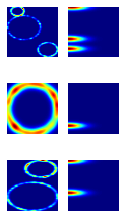

In [17]:
j = 18
plt.figure(figsize=(2, 4))

for i in range(3):
    #plt.subplot(3, 3, 3 * i + 1)
    #PC = np.reshape(predictions[i, :dim * N_points], (N_points, dim))
    #plt.scatter(PC_test[i+j, :, 0], PC_test[i+j, :, 1], s=3)
    #plt.xlim(-1, 1)
    #plt.ylim(-1, 1)
    #plt.axis('equal')
    plt.subplot(3, 2, 2 * i + 1)
    #im = predictions[i, dim * N_points:]
    plt.imshow(np.flip(np.reshape(density_test[i+j], [size, size]), 0),
               cmap='jet')
    #plt.colorbar()
    plt.axis('off')

    plt.subplot(3, 2, 2 * i + 2)
    #im = predictions[i, dim * N_points:]
    plt.imshow(np.flip(np.reshape(PI_test[i+j], [PI_size, PI_size]), 0),
               vmin=0,
               vmax=1,
               cmap='jet')
    #plt.colorbar()
    plt.axis('off')
#plt.savefig("../Rapports/Rapport_PRe/Images/VAE_multiple_circles_true_PC_PI.pdf")

This are the real point clouds corresponding

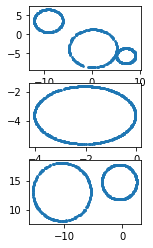

In [16]:
plt.figure(figsize=(2, 4))

plt.subplot(3,1,1)
plt.scatter(PC_test[18,:,0],PC_test[18,:,1],s=3)
plt.subplot(3,1,2)
plt.scatter(PC_test[19,:,0],PC_test[19,:,1],s=3)
plt.subplot(3,1,3)
plt.scatter(PC_test[20,:,0],PC_test[20,:,1],s=3)
plt.axis("equal")
#plt.savefig("../Rapports/Rapport_PRe/Images/VAE_multiple_circles_true_PC.pdf")

### Try to predict a couple of (PI,density) given only one of the two modalities

#### Predict a density from a PI

To do this we give the PIs encoder the PIs

In [28]:
z_mean_PI, z_var_PI = vae.encoder_PI(PI_test)

2021-07-22 14:30:46.141178: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 19980000 exceeds 10% of free system memory.


From the $(\mu_{PI},\sigma_{PI})$ we get from the PIs encoder we can compute $(\mu_{joint},\sigma_{joint})$

In [29]:
mean_joint = (z_mean_PI / z_var_PI) * (1 + 1 / z_var_PI)
var_joint = (1 + 1 / z_var_PI)

We then sample $z_{joint}$ from $\mathcal N(\mu_{joint},\sigma_{joint})$

In [30]:
z_joint = vae.sampling((mean_joint, var_joint))

We can then decode $z_{joint}$ to a couple of (PI,density)

In [31]:
z_PI, z_PC = tf.split(vae.shared_decoder(z_joint),
                      num_or_size_splits=2,
                      axis=1)

reconstructed_PI = vae.decoder_PI(z_PI)
reconstructed_PC = vae.decoder_PC(z_PC)

We then plot them

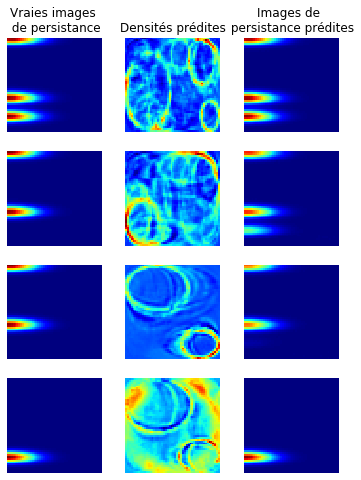

In [38]:
fig = plt.figure(figsize=(6,8))

for i in range(4):
    if i == 0:
        plt.subplot(4, 3, 3 * i + 2).set_title('Densités prédites')
    else:
        plt.subplot(4, 3, 3 * i + 2)
    plt.imshow(np.flip(np.reshape(reconstructed_PC[i+3], [size, size]), 0),
               cmap='jet')
    #plt.colorbar()
    plt.axis('off')
    if i == 0:
        plt.subplot(4, 3, 3 * i + 3).set_title('Images de \n persistance prédites')
    else:
        plt.subplot(4, 3, 3 * i + 3)
    plt.imshow(np.flip(
        np.reshape(reconstructed_PI[i+3], [PI_size, PI_size]), 0),
               vmin=0,
               vmax=1,
               cmap='jet')
    #plt.colorbar()
    plt.axis('off')
    if i == 0:
        plt.subplot(4, 3, 3 * i + 1).set_title('Vraies images \n de persistance')
    else:
        plt.subplot(4, 3, 3 * i + 1)
    plt.imshow(np.flip(np.reshape(PI_test[i+3], [size, size]), 0),
               cmap='jet')
    #plt.colorbar()
    plt.axis('off')

#plt.savefig("../Rapports/Rapport_PRe/Images/VAE_multiple_circles_predict_density_from_PI.pdf")

#### Predict a PI from a density 

Here we do the same thing but with a density at the start : we give the PCs encoder the densities

In [21]:
z_mean_PC, z_var_PC = vae.encoder_PC(density_test)

2021-07-29 10:43:58.218417: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 19980000 exceeds 10% of free system memory.


From the $(\mu_{PC},\sigma_{PC})$ we get from the PCs encoder we can compute $(\mu_{joint},\sigma_{joint})$

In [22]:
mean_joint = (z_mean_PC / z_var_PC) * (1 + 1 / z_var_PC)
var_joint = (1 + 1 / z_var_PC)

We then sample $z_{joint}$ from $\mathcal N(\mu_{joint},\sigma_{joint})$

In [23]:
z_joint = vae.sampling((mean_joint, var_joint))

We can then decode $z_{joint}$ to a couple of (PI,density)

In [24]:
z_PI, z_PC = tf.split(vae.shared_decoder(z_joint),
                      num_or_size_splits=2,
                      axis=1)

reconstructed_PI = vae.decoder_PI(z_PI)
reconstructed_PC = vae.decoder_PC(z_PC)

We then plot them

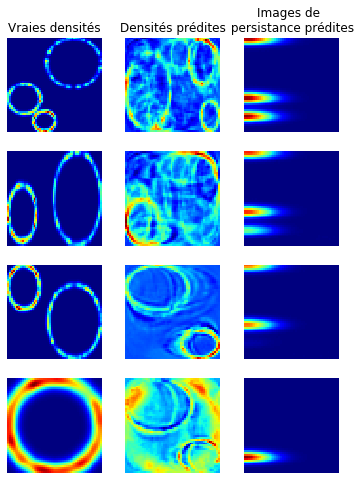

In [33]:
fig = plt.figure(figsize=(6,8))
for i in range(4):
    if i == 0:
        plt.subplot(4, 3, 3 * i + 1).set_title('Vraies densités')
    else:
        plt.subplot(4, 3, 3 * i + 1)
    plt.imshow(np.flip(np.reshape(density_test[i+3], [size, size]), 0),
               cmap='jet')
    #plt.colorbar()
    plt.axis('off')
    if i == 0:
        plt.subplot(4, 3, 3 * i + 2).set_title('Densités prédites')
    else:
        plt.subplot(4, 3, 3 * i + 2)
    plt.imshow(np.flip(np.reshape(reconstructed_PC[i+3], [size, size]), 0),
               cmap='jet')
    #plt.colorbar()
    plt.axis('off')
    if i == 0:
        plt.subplot(4, 3, 3 * i + 3).set_title('Images de \n persistance prédites')
    else:
        plt.subplot(4, 3, 3 * i + 3)
    plt.imshow(np.flip(
        np.reshape(reconstructed_PI[i+3], [PI_size, PI_size]), 0),
               vmin=0,
               vmax=1,
               cmap='jet')
    #plt.colorbar()
    plt.axis('off')

plt.savefig("../Rapports/Rapport_PRe/Images/VAE_multiple_circles_predict_PI_from_density.pdf")

### Study of the latent distribution 

To study the latent distribution we comupte the $(\mu_{joint},\sigma_{joint})$ for the testing data, and we compute the mean of $\mu_{joint}$ and of $\sigma_{joint}$ for the data representing a one, two and three circles.

We can then encode this into a `multivariate_normal` object. Since the latente distribution is in 3D, we cannot plot the gaussian but we draw 1000 points from it and plot those points.

In [4]:
from multiple_circle import create_random_circle, create_1_circle, create_2_circle, create_3_circle

In [5]:
size = 50
PI_size = 50

In [12]:
nb_cercles = 50
N_points = 600

PI_rep = gd.representations.PersistenceImage(bandwidth=1,
                                             weight=lambda x: 10 *
                                             np.tanh(x[1]),
                                             resolution=[PI_size, PI_size], im_range=[0, 5, 0, 25])

circles_1 = np.zeros((nb_cercles, N_points, 2))
density_1 = np.zeros((nb_cercles, size * size))
PI_1 = np.zeros((nb_cercles, PI_size * PI_size))
for i in tqdm(range(nb_cercles)):
    circles_1[i] = create_1_circle(N_points)
    x_sample = np.linspace(np.min(circles_1[i, :, 0]), np.max(circles_1[i, :, 0]), size)
    y_sample = np.linspace(np.min(circles_1[i, :, 1]), np.max(circles_1[i, :, 1]), size)
    #xx, yy = np.meshgrid(x_sample, y_sample)
    coord = np.array([[x, y] for x in x_sample for y in y_sample])
    kde = KernelDensity(kernel='gaussian', bandwidth=0.25).fit(circles_1[i])
    density_1[i] = np.exp(kde.score_samples(coord))

    rcX = gd.AlphaComplex(points=circles_1[i]).create_simplex_tree()
    dgmX = rcX.persistence()
    pi = PI_rep.fit_transform([rcX.persistence_intervals_in_dimension(1)])
    PI_1[i] = pi[0]

z_mean_PC_1, z_var_PC_1 = vae.encoder_PC(density_1)
z_mean_PI_1, z_var_PI_1 = vae.encoder_PI(PI_1)

mean_joint_1 = (z_mean_PI_1 / z_var_PI_1 +
              z_mean_PC_1 / z_var_PC_1) * (1 + 1 / z_var_PI_1 + 1 / z_var_PC_1)
var_joint_1 = (1 + 1 / z_var_PI_1 + 1 / z_var_PC_1)

100%|███████████████████████████████████████████| 50/50 [00:06<00:00,  7.17it/s]


In [13]:
circles_2 = np.zeros((nb_cercles, N_points, 2))
density_2 = np.zeros((nb_cercles, size * size))
PI_2 = np.zeros((nb_cercles, PI_size * PI_size))
for i in tqdm(range(nb_cercles)):
    circles_2[i] = create_2_circle(N_points)
    x_sample = np.linspace(np.min(circles_2[i, :, 0]), np.max(circles_2[i, :, 0]), size)
    y_sample = np.linspace(np.min(circles_2[i, :, 1]), np.max(circles_2[i, :, 1]), size)
    #xx, yy = np.meshgrid(x_sample, y_sample)
    coord = np.array([[x, y] for x in x_sample for y in y_sample])
    kde = KernelDensity(kernel='gaussian', bandwidth=0.25).fit(circles_2[i])
    density_2[i] = np.exp(kde.score_samples(coord))

    rcX = gd.AlphaComplex(points=circles_2[i]).create_simplex_tree()
    dgmX = rcX.persistence()
    pi = PI_rep.fit_transform([rcX.persistence_intervals_in_dimension(1)])
    PI_2[i] = pi[0]

z_mean_PC_2, z_var_PC_2 = vae.encoder_PC(density_2)
z_mean_PI_2, z_var_PI_2 = vae.encoder_PI(PI_2)

mean_joint_2 = (z_mean_PI_2 / z_var_PI_2 +
              z_mean_PC_2 / z_var_PC_2) * (1 + 1 / z_var_PI_2 + 1 / z_var_PC_2)
var_joint_2 = (1 + 1 / z_var_PI_2 + 1 / z_var_PC_2)

100%|███████████████████████████████████████████| 50/50 [00:06<00:00,  7.89it/s]


In [14]:
circles_3 = np.zeros((nb_cercles, N_points, 2))
density_3 = np.zeros((nb_cercles, size * size))
PI_3 = np.zeros((nb_cercles, PI_size * PI_size))
for i in tqdm(range(nb_cercles)):
    circles_3[i] = create_3_circle(N_points)
    x_sample = np.linspace(np.min(circles_3[i, :, 0]), np.max(circles_3[i, :, 0]), size)
    y_sample = np.linspace(np.min(circles_3[i, :, 1]), np.max(circles_3[i, :, 1]), size)
    #xx, yy = np.meshgrid(x_sample, y_sample)
    coord = np.array([[x, y] for x in x_sample for y in y_sample])
    kde = KernelDensity(kernel='gaussian', bandwidth=0.25).fit(circles_3[i])
    density_3[i] = np.exp(kde.score_samples(coord))

    rcX = gd.AlphaComplex(points=circles_3[i]).create_simplex_tree()
    dgmX = rcX.persistence()
    pi = PI_rep.fit_transform([rcX.persistence_intervals_in_dimension(1)])
    PI_3[i] = pi[0]

z_mean_PC_3, z_var_PC_3 = vae.encoder_PC(density_3)
z_mean_PI_3, z_var_PI_3 = vae.encoder_PI(PI_3)

mean_joint_3 = (z_mean_PI_3 / z_var_PI_3 +
              z_mean_PC_3 / z_var_PC_3) * (1 + 1 / z_var_PI_3 + 1 / z_var_PC_3)
var_joint_3 = (1 + 1 / z_var_PI_3 + 1 / z_var_PC_3)

100%|███████████████████████████████████████████| 50/50 [00:06<00:00,  8.06it/s]


In [15]:
gauss_1 = multivariate_normal(mean=np.mean(z_mean_PC_1, 0),
                              cov=np.mean(np.abs(var_joint_1), 0))

gauss_2 = multivariate_normal(mean=np.mean(z_mean_PC_2, 0),
                              cov=np.mean(np.abs(var_joint_2), 0))

gauss_3 = multivariate_normal(mean=np.mean(z_mean_PC_3, 0),
                              cov=np.mean(np.abs(var_joint_3), 0))

gauss_0_1 = multivariate_normal(mean=[0, 0, 0])

In [16]:
sample_1 = gauss_1.rvs(1000)
sample_2 = gauss_2.rvs(1000)
sample_3 = gauss_3.rvs(1000)

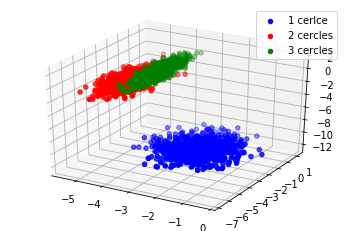

In [20]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(sample_1[:,0],sample_1[:,1],sample_1[:,2],c="blue")
ax.scatter(sample_2[:,0],sample_2[:,1],sample_2[:,2],c="red")
ax.scatter(sample_3[:,0],sample_3[:,1],sample_3[:,2],c="green")

plt.legend(["1 cerlce","2 cercles","3 cercles"])
#plt.savefig("../Rapports/Rapport_PRe/Images/VAE_multiple_circles_latente.pdf")

### Generate random $z_{joint}$

We try to generate a random $z_{joint}$ from $\mathcal N((10,10,10),I_3)$. We then decode this random $z_{joint}$ and plot the PI and density we get from it.

In [90]:
z_joint = np.random.normal(size=(4, 3),scale=[10,10,10]) #loc=[15,-4]
z_PI, z_PC = tf.split(vae.shared_decoder(z_joint),
                      num_or_size_splits=2,
                      axis=1)

reconstructed_PI = vae.decoder_PI(z_PI)
reconstructed_PC = vae.decoder_PC(z_PC)

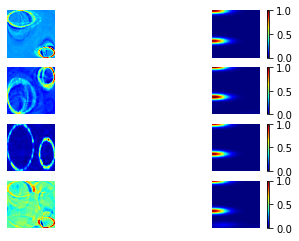

In [91]:
for i in range(4):
    plt.subplot(4, 2, 2 * i + 2)
    plt.imshow(np.flip(np.reshape(reconstructed_PI[-i], [PI_size, PI_size]),
                       0),
               vmin=0,
               vmax=1,
               cmap='jet')
    plt.colorbar()
    plt.axis('off')
    plt.subplot(4, 2, 2 * i + 1)
    plt.imshow(np.flip(np.reshape(reconstructed_PC[-i], [size, size]), 0),
               cmap='jet')
    #plt.colorbar()
    plt.axis('off')

### Go from one circle to two circles 

To go from a square to a circle, we arrange N $z_{joint}$ from center of the latent distribution representing one circle to the center of the latent distribution representing two circles. We can then decode those $z_{joint}$ and plot the output.

In [167]:
N = 20

In [168]:
z_mean_PC, z_var_PC = vae.encoder_PC([density_test[12],density_test[13]])
z_mean_PI, z_var_PI = vae.encoder_PI([PI_test[12],PI_test[13]])

mean_joint  = (z_mean_PI  / z_var_PI  +
              z_mean_PC  / z_var_PC ) * (1 + 1 / z_var_PI  + 1 / z_var_PC )
var_joint  = (1 + 1 / z_var_PI  + 1 / z_var_PC )

In [169]:
z_joint = np.linspace(mean_joint[0],mean_joint[1],N)

In [170]:
z_PI, z_PC = tf.split(vae.shared_decoder(z_joint),
                      num_or_size_splits=2,
                      axis=1)

reconstructed_PI = vae.decoder_PI(z_PI)
reconstructed_PC = vae.decoder_PC(z_PC)

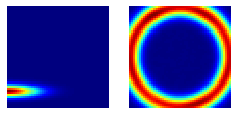

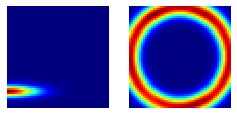

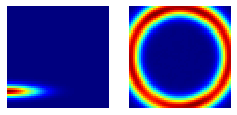

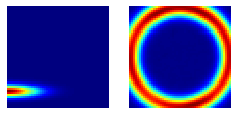

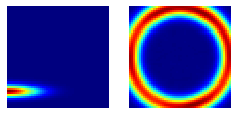

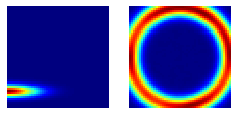

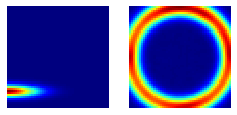

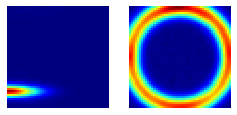

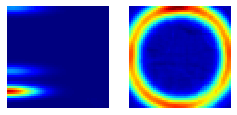

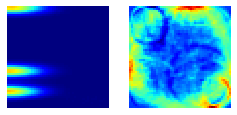

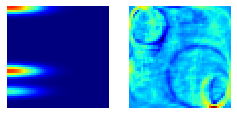

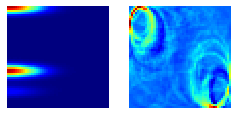

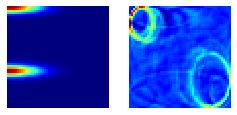

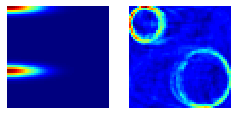

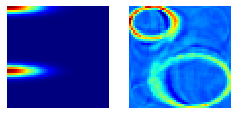

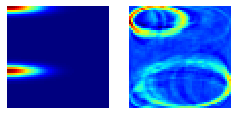

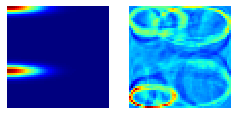

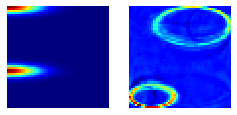

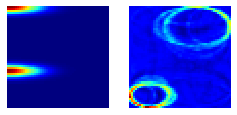

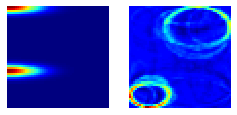

In [171]:
for i in range(N):
    plt.figure(figsize=(4, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(np.flip(np.reshape(reconstructed_PI[i], [PI_size, PI_size]), 0),
               vmin=0,
               vmax=1,
               cmap='jet',
               aspect='equal')
    #plt.colorbar()
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(np.flip(np.reshape(reconstructed_PC[i], [size, size]), 0),
               cmap='jet',
               aspect='equal')
    #plt.colorbar()
    plt.axis('off')
    #plt.savefig("Résultats/from_square_to_circle_"+str(i)+".png")